<a href="https://colab.research.google.com/github/zemimoh/gompertz/blob/main/gompertz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Section
Import packages


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters 
##needed to properly use datetime in plots
register_matplotlib_converters()  
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

#Load Data
Define URL of data source and import data into Pandas

In [15]:
giturl_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/c6398b144172293cc21b9ef2f9c6f95d96e7e1ed/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
giturl_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
giturl_recovered = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

casestr='Confirmed'   #'Confirmed' #'Recovered', 'Deaths'
chosen_plotmodel = 'Logistic'  #'Logistc'

if casestr=='Confirmed':
    curl = giturl_confirmed
elif casestr=='Deaths':
    curl = giturl_deaths
elif casestr=='Recovered':
    curl = giturl_recovered
    
corona_cases_df=pd.read_csv(curl, index_col=[0,1,2,3])
#   use first four columns as multiindex
corona_cases_df.columns.values

array(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/2/20',
       '2/3/20', '2/4/20', '2/5/20', '2/6/20', '2/7/20', '2/8/20',
       '2/9/20', '2/10/20', '2/11/20', '2/12/20', '2/13/20', '2/14/20',
       '2/15/20', '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20',
       '2/21/20', '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20',
       '2/27/20', '2/28/20', '2/29/20', '3/1/20', '3/2/20', '3/3/20',
       '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20', '3/9/20',
       '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20', '3/15/20',
       '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20', '3/21/20',
       '3/22/20', '3/23/20', '3/24/20', '3/25/20', '3/26/20', '3/27/20',
       '3/28/20', '3/29/20', '3/30/20', '3/31/20', '4/1/20', '4/2/20',
       '4/3/20', '4/4/20', '4/5/20', '4/6/20', '4/7/20', '4/8/20',
       '4/9/20', '4/10/20', '4/11/20', '4/12/20', '4/13/20', '4/14/20',
     

Format date strings using datetime

In [16]:
datesformatted = [datetime.strptime(da, '%m/%d/%y') 
                  for da in corona_cases_df.columns.values]

daterange = pd.DatetimeIndex(datesformatted)
daterange

DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31',
               ...
               '2021-03-29', '2021-03-30', '2021-03-31', '2021-04-01',
               '2021-04-02', '2021-04-03', '2021-04-04', '2021-04-05',
               '2021-04-06', '2021-04-07'],
              dtype='datetime64[ns]', length=442, freq=None)

#Creating a new DataFrame of aggregated data
Extracting wanted countries

In [17]:
country_official_list = (corona_cases_df.index.get_level_values('Country/Region').values)

wanted_countries = ['China', 'Korea','Italy', 'France', 'US']

countries_list = [np.unique(np.array([s for s in country_official_list if cou in s])) 
                                                 for cou in wanted_countries]
countries_list = np.array(countries_list).flatten()
countries_list.sort()
countries_list

array(['China', 'France', 'Italy', 'Korea, South', 'US'], dtype='<U12')

In [18]:
cases_percountry = {}
df_dict = {}
for country in countries_list:
    cou = corona_cases_df.loc[pd.IndexSlice[:, country], :].sum()
    cases_percountry[country] = cou[cou > 0]
    datesformat = [datetime.strptime(da, '%m/%d/%y') 
                   for da in cases_percountry[country].index]
    
    df_dict[country] = pd.DataFrame(cases_percountry[country], 
                                    columns=['Cases'], index=datesformat)
    df_dict[country]['DayCount'] = np.arange(1, 
                                             cases_percountry[country].shape[0]+1)
    
    
print(df_dict['Italy']['Cases'][::3])  #print cases every three days

2020-01-31          2
2020-02-03          2
2020-02-06          2
2020-02-09          3
2020-02-12          3
               ...   
2021-03-26    3488619
2021-03-29    3544957
2021-04-01    3607083
2021-04-04    3668264
2021-04-07    3700393
Name: Cases, Length: 145, dtype: int64


#Plotting the different country DataFrames
Confirmed Coronavirus cases for the current data range

China
France
Italy
Korea, South
US


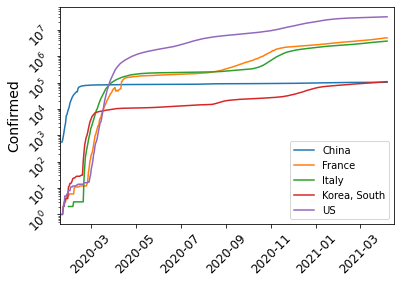

In [19]:
for country in countries_list:
    print(country)
    dates=df_dict[country].index
    plt.semilogy(dates, np.array(list(df_dict[country]['Cases'].values)), label=country)
    plt.legend(loc='lower right')
    plt.tick_params(rotation=45, labelsize=12)
    plt.ylabel(casestr, fontsize=14)
plt.xlim([dates[0]-np.timedelta64(3,'D'), dates[-1]+np.timedelta64(10,'D')])
plt.show()

#Predection Models
Defining the Models

In [20]:
def expo_model(x,p,N0=3,x0=1):
    return N0*(1+p)**(x-x0)

def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

def gompertz_model(x,a,b,c):
    return c*np.exp(-b*np.exp(-x/a))

Comparison of the three models considered in this work

(-1000.0, 150000.0)

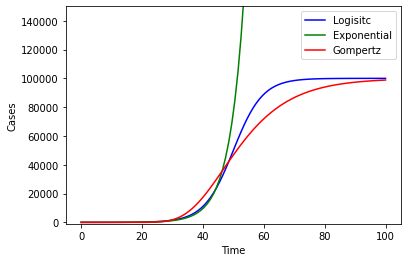

In [21]:
tt= np.linspace(0,100,100)
plt.plot(tt, logistic_model(tt,4.8,50,100000), c='b', label='Logisitc')
plt.plot(tt, expo_model(tt, 0.23), c='g', label='Exponential')
plt.plot(tt, gompertz_model(tt, 12, 49, 100000), c='r', label='Gompertz')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Cases')
plt.ylim(-1000,150000)

#Fitting the data to the models

In [22]:
leaveout = -1

for country in countries_list:
    print('----')
    print('Country: ', country)
    if leaveout==0:
      leaveout=None
    #filter = corona_cases_df.iso_code.str.contains(country)
    #country_data = corona_cases_df[filter]

    x = np.array(list(df_dict[country]['DayCount'].values))[0:leaveout]  ##remove last data point to make prediction
    y = np.array(list(df_dict[country]['Cases'].values))[0:leaveout]    ##remove last data point to make prediction

    y0 = y[0]
    yf = y[-1]
    print("Initial number of cases: ", y0)
    print("Current number of cases: ", yf)

----
Country:  China
Initial number of cases:  548
Current number of cases:  101920
----
Country:  France
Initial number of cases:  2
Current number of cases:  4902025
----
Country:  Italy
Initial number of cases:  2
Current number of cases:  3686707
----
Country:  Korea, South
Initial number of cases:  1
Current number of cases:  106898
----
Country:  US
Initial number of cases:  1
Current number of cases:  30847348


Fit model to data, by choosing appropriate initial values p0

In [23]:
    print('>>> Logistic Model')
    fit_i = curve_fit(logistic_model,x,y,p0=[3,20,5000], maxfev=10000)#, bounds=([0,0,0],[10,100,150000]))
    ai,bi,ci = fit_i[0]
    sigma_ai, sigma_bi, sigma_ci = np.sqrt(np.diag(fit_i[1]))
    c_pars = {}
    c_pars[(country,'Logistic','a')] = ai
    c_pars[(country,'Logistic','b')] = bi
    c_pars[(country,'Logistic','c')] = ci
    c_pars[(country,'Logistic','sga')] = sigma_ai
    c_pars[(country,'Logistic','sgb')] = sigma_bi
    c_pars[(country,'Logistic','sgc')] = sigma_ci
    print([ss+'='+'{:.3f}'.format(xx) for ss, xx in zip(('a','b','c'),
                                                        (ai,bi,ci))])
    print([ss+'='+'{:.3f}'.format(xx) for ss, xx in zip(('sigma_a','sigma_b','sigma_c'),
                                                        (sigma_ai,sigma_bi,sigma_ci))])

>>> Logistic Model
['a=63.972', 'b=346.323', 'c=39870296.138']
['sigma_a=1.054', 'sigma_b=2.489', 'sigma_c=639818.542']


#Predection
Calculating goodness of fit and asymtpote date

In [25]:
y_pred = logistic_model(x,ai,bi,ci)
MSLE=sklm.mean_squared_log_error(y,y_pred)
print("Mean squared log error (MSLE): ", '{:.3f}'.format(MSLE))
print("Exp of RMSLE: ", '{:.3f}'.format(np.exp(np.sqrt(MSLE))))
print("R2 score: ", '{:.3f}'.format(sklm.r2_score(y,y_pred)))

perc_flat = 0.98
sol = int(fsolve(lambda x : logistic_model(x,ai,bi,ci) - perc_flat*int(ci), bi))
print('Day of flattening of the infection curve')
datesol = datetime.strftime(df_dict[country].index[0] + timedelta(days=sol), ' %d, %b %Y' )
print('-->'+datesol)
c_pars[(country,'Logistic','c_time')] = sol

NameError: ignored

# Computing some predictions

Calculate predictions for the last day

In [ ]:
chosenmodel='Logistic'

if chosenmodel=="Logistic":
    print("Chosen Model: ", chosenmodel)
    reg_model = logistic_model
elif chosenmodel=='Gompertz':
    print("Chosen Model: ", chosenmodel)
    reg_model = gompertz_model


for country in countries_list:
  print("\n ***Country: "+str(country))
  x = np.array(list(df_dict[country]['DayCount'].values))
  print("Used data, Day Count: ", x[-1+leaveout])
  print("Used data, Last day date: ", datetime.strftime(df_dict[country].index[-1+leaveout], ' %d, %b %Y' ))
  y = np.array(list(df_dict[country]['Cases'].values))
  print("Used data, Number of cases: "+casestr+" in the last day: ", y[-1+leaveout])
  print("---")
  pred_days = 0
  day = x[-1]+pred_days
  pred_date = datetime.strftime(df_dict[country].index[-1] + timedelta(days=pred_days), ' %d, %b %Y' )
  print("Prediction for: ", pred_date)
  
  realdat = y[-1]


  a,b,c = (c_pars[(country,chosenmodel,par)] for par in ['a','b','c'])
  sigma_a,sigma_b,sigma_c = (c_pars[(country,chosenmodel,par)] for par in ['sga','sgb','sgc'])

  prediction = reg_model(day,a,b,c)
  pluspred = np.abs(reg_model(day,np.abs(a+sigma_a),np.abs(b+sigma_b),np.abs(c+sigma_c)))
  minuspred = np.abs(reg_model(day,np.abs(a-sigma_a),np.abs(b-sigma_b),np.abs(c-sigma_c)))

  print("Prediction from "+chosenmodel+" Model : ", frm(prediction), ' ( +'+frm(pluspred-prediction)+', -'+frm(prediction-minuspred)+')')

  print("Real data: ", frm(realdat))
  prediction_error_perc = 100*(prediction-realdat)/realdat
  print("Prediction Percentage error: ", '{:2f}'.format(prediction_error_perc), '%')

Choosing the colormap

In [27]:
color_list = plt.cm.Set1( np.linspace(0.,1.0, 9 ) )
color_iter = iter(color_list)
...
...
col=next(color_iter)

Creating the date range for the plot

In [ ]:
#getting the saved asymptote
flatasymp = max([c_pars[(country,chosen_plotmodel,'c_time')] for country in countries_list])+1

#finding the minimum date, namely date of first case among chosen countries
mindate = min([df_dict[country].index[0] for country in countries_list])

#creating a date range for the plot for each country
pred_date = pd.date_range(start=df_dict[country].index[0], periods=flatasymp).values

# using the mindate - 3days and the last predicted date + 3days for the x-limits of the plot
ax.set_xlim([mindate-np.timedelta64(3,'D'), pred_date[-1]+np.timedelta64(3,'D')])

Plotting the data, the mean of the models and their confidence contours

In [ ]:
ax.scatter(df_dict[country].index ,y ,label=country,color=col)# Predicted logistic curve

ax.plot(pred_date, mean, 
        label=chosen_plotmodel+" model", color=col)  #Predicted Logistic Curve

ax.fill_between(pred_date, upper_lim, lower_lim, color=col, alpha=0.4)

ax.plot(pred_date, [expo_model(i,p, N0=y0) for i in pred_x], '--', 
        label="Exponential model", color=col)